![](https://drive.google.com/uc?export=view&id=1oMxyESSVJV2cpC2-2R_BVqDnpPZgzQ_8)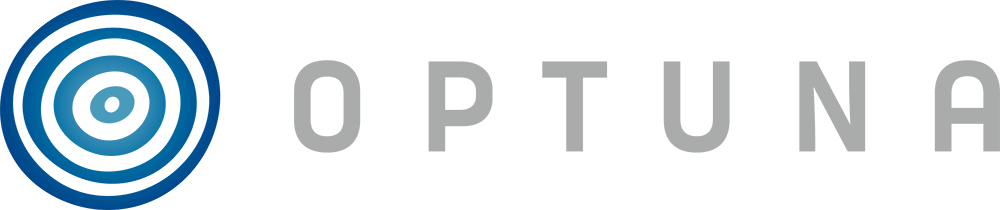

# 💡 **Optuna**

Optuna es una biblioteca de optimización de hiperparámetros automatizada y eficiente para modelos de machine learning. Utiliza búsqueda bayesiana y otras estrategias avanzadas para encontrar los valores óptimos de hiperparámetros, minimizando o maximizando una función objetivo definida por el usuario. Es especialmente útil cuando se quiere mejorar el rendimiento de modelos sin tener que hacer búsqueda manual.

### 🛠 **Instalación de Optuna**
Se instala la biblioteca `optuna`, utilizada para la optimización de hiperparámetros en modelos de machine learning.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 7.5 MB/s eta 0:00:00


### ✅ **Importación de bibliotecas**
Se importan las bibliotecas necesarias: `optuna`, `pandas`, `numpy`, y los módulos de `scikit-learn` para modelos, métricas, preprocesamiento y validación.


In [ ]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

### ✅ **Carga de datos**
Se cargan los datos de entrada en un DataFrame de Pandas. Estos datos corresponden a estadísticas de Pokémon, usados para tareas de regresión y clasificación.


In [ ]:
# Cargar datos
data = pd.read_csv("pokemon.csv")

# Imputaciones básicas
data['height_m'] = data.groupby('type1')['height_m'].transform(lambda x: x.fillna(x.mean()))
data['weight_kg'] = data.groupby('type1')['weight_kg'].transform(lambda x: x.fillna(x.mean()))
data['percentage_male'].fillna(data['percentage_male'].mean(), inplace=True)

# Codificar type1 y type2
label_encoders = {}
for col in ['type1', 'type2']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Escalar algunas columnas
scaler = StandardScaler()
data[['height_m', 'weight_kg']] = scaler.fit_transform(data[['height_m', 'weight_kg']])

<ipython-input-22-d566e0ddc8c9>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['percentage_male'].fillna(data['percentage_male'].mean(), inplace=True)


# 💡 **Parte 1: Regresión con Optuna**

### ✅ **Tarea de regresión: predecir 'sp_attack'**
Se selecciona la variable `'sp_attack'` como objetivo de regresión y se preparan los datos para entrenamiento y prueba.

In [ ]:
# Objetivo: predecir 'sp_attack' (como ejemplo de regresión)
features_reg = ['height_m', 'weight_kg', 'speed', 'attack', 'defense', 'sp_defense', 'generation', 'percentage_male']
X_reg = data[features_reg]
y_reg = data['sp_attack']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=0)

### ✅ **Optimización con Optuna: Ridge Regression**
Se define una función objetivo que será optimizada por Optuna para encontrar el mejor valor del hiperparámetro `alpha` en Ridge Regression.


In [ ]:
# Optimización para Ridge Regression

def objective_ridge(trial):
    alpha = trial.suggest_float("alpha", 0.01, 10.0)
    model = Ridge(alpha=alpha)
    score = -cross_val_score(model, X_train_reg, y_train_reg, scoring="neg_mean_squared_error", cv=3).mean()
    return score

study_ridge = optuna.create_study(direction="minimize")
study_ridge.optimize(objective_ridge, n_trials=30)
print("Ridge - Mejor alpha:", study_ridge.best_params)

[I 2025-05-08 07:43:33,249] A new study created in memory with name: no-name-b88c1df6-02c5-41f3-9bbf-8f2ea50675d6
[I 2025-05-08 07:43:33,274] Trial 0 finished with value: 640.7899306141094 and parameters: {'alpha': 6.297289911373616}. Best is trial 0 with value: 640.7899306141094.
[I 2025-05-08 07:43:33,291] Trial 1 finished with value: 640.800949847063 and parameters: {'alpha': 6.1919003502740795}. Best is trial 0 with value: 640.7899306141094.
[I 2025-05-08 07:43:33,310] Trial 2 finished with value: 640.9172549529056 and parameters: {'alpha': 5.090995453786882}. Best is trial 0 with value: 640.7899306141094.
[I 2025-05-08 07:43:33,330] Trial 3 finished with value: 640.5762523661164 and parameters: {'alpha': 8.37920969694133}. Best is trial 3 with value: 640.5762523661164.
[I 2025-05-08 07:43:33,349] Trial 4 finished with value: 641.3906660657516 and parameters: {'alpha': 0.8150174613468203}. Best is trial 3 with value: 640.5762523661164.
[I 2025-05-08 07:43:33,368] Trial 5 finished w

Ridge - Mejor alpha: {'alpha': 9.994696363280282}


### ✅ **Evaluación del modelo Ridge optimizado**
Una vez Optuna encuentra el mejor `alpha`, se entrena un modelo de Ridge Regression con ese valor y se evalúa con error cuadrático medio (RMSE).


In [ ]:
# Evaluar Ridge
ridge_model = Ridge(**study_ridge.best_params)
ridge_model.fit(X_train_reg, y_train_reg)
preds_ridge = ridge_model.predict(X_test_reg)
print("Ridge - MSE:", mean_squared_error(y_test_reg, preds_ridge))

Ridge - MSE: 657.3402935981878


### ✅ **Regresión Lineal como base comparativa**
Se entrena un modelo de regresión lineal sin regularización para comparar su desempeño contra Ridge optimizado.


In [ ]:
# Linear Regression (sin Optuna como comparación)
lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)
preds_lr = lr.predict(X_test_reg)
print("LinearRegression - MSE:", mean_squared_error(y_test_reg, preds_lr))

LinearRegression - MSE: 657.17020223849


# 💡 **Parte 2: Clasificación con Optuna**

### ✅ **Tarea de clasificación: ¿Es un Pokémon legendario?**
Se convierte la variable objetivo a binaria (`True/False`) para clasificar si un Pokémon es legendario o no, y se dividen los datos.


In [ ]:
# Objetivo: predecir si un Pokémon es legendario
features_cls = [
    'height_m', 'weight_kg', 'speed', 'attack', 'defense',
    'sp_attack', 'sp_defense', 'generation', 'percentage_male',
    'type1', 'type2'
] + [col for col in data.columns if col.startswith("against_")]

X_cls = data[features_cls]
y_cls = data['is_legendary']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.3, stratify=y_cls, random_state=0)

# Random Forest

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    model = RandomForestClassifier(**params, random_state=0)
    return cross_val_score(model, X_train_cls, y_train_cls, cv=3, scoring='accuracy').mean()

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=30)
print("Random Forest - Mejores hiperparámetros:", study_rf.best_params)

[I 2025-05-08 07:20:03,285] A new study created in memory with name: no-name-364a2318-c2e5-4ee6-933e-af114520d580
[I 2025-05-08 07:20:04,539] Trial 0 finished with value: 0.9428631667720851 and parameters: {'n_estimators': 170, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9428631667720851.
[I 2025-05-08 07:20:04,970] Trial 1 finished with value: 0.9321392291031759 and parameters: {'n_estimators': 52, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9428631667720851.
[I 2025-05-08 07:20:06,652] Trial 2 finished with value: 0.9375059896881529 and parameters: {'n_estimators': 246, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9428631667720851.
[I 2025-05-08 07:20:07,042] Trial 3 finished with value: 0.9339217602974719 and parameters: {'n_estimators': 77, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 0 with value:

Random Forest - Mejores hiperparámetros: {'n_estimators': 212, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1}


### ✅ **XGBoost Classifier**
Se entrena un modelo `XGBoostClassifier` y se mide su precisión sobre el conjunto de prueba. XGBoost es potente y robusto, ideal para tareas clasificatorias complejas.


In [ ]:
# XGBoost

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    return cross_val_score(model, X_train_cls, y_train_cls, cv=3, scoring='accuracy').mean()

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=30)
print("XGBoost - Mejores hiperparámetros:", study_xgb.best_params)

[I 2025-05-08 07:20:34,463] A new study created in memory with name: no-name-ac172194-00c3-4b6e-8434-23fd7ef78241
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:20:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:20:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:20:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-08 07:20:34,837] Trial 0 finished with value: 0.9571617503306308 and parameters: {'max_depth': 11, 'learning_rate': 0.22729657889695346, 'n_estimators': 298, 'subsample': 0.6482350971725217, 'colsample_bytree': 0.8515136919614068}. Best is

XGBoost - Mejores hiperparámetros: {'max_depth': 8, 'learning_rate': 0.12961162801170087, 'n_estimators': 124, 'subsample': 0.9506848118404426, 'colsample_bytree': 0.704178910261685}


### ✅ **Regresión Logística**
Se entrena un modelo de regresión logística sobre los datos escalados para clasificación. Se imprime la precisión del modelo.


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cls)
X_test_scaled = scaler.transform(X_test_cls)

# Logistic Regression (comparativa)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train_cls)
preds_log = log_reg.predict(X_test_scaled)
print("Logistic Regression - Accuracy:", accuracy_score(y_test_cls, preds_log))

Logistic Regression - Accuracy: 0.9336099585062241


### ✅ **K-Nearest Neighbors (KNN)**
Se entrena un clasificador KNN y se mide su precisión. Este algoritmo predice la clase de un punto en base a la mayoría de los vecinos más cercanos.


In [ ]:
# K-Nearest Neighbors (comparativa)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_cls, y_train_cls)
preds_knn = knn.predict(X_test_cls)
print("K-NN (k=5) - Accuracy:", accuracy_score(y_test_cls, preds_knn))

K-NN (k=5) - Accuracy: 0.9253112033195021
